In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [30]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNEL=3
EPOCHS=10

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "Tomato_data",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
class_names= dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(dataset)
#becauz every element in the dataset is a batch of 32 image :501*32=16032, 1bath contain 32 images

501

In [6]:
for image_batch, label_batch in dataset.take(1):
    print( image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[7 8 5 5 7 4 7 9 4 7 4 0 6 6 8 6 3 2 2 6 0 5 2 7 7 5 2 7 1 7 3 7]


In [7]:
for image_batch, label_batch in dataset.take(1):
    print( image_batch[0])
    print(label_batch[0].numpy())

tf.Tensor(
[[[145. 135. 146.]
  [146. 136. 147.]
  [147. 137. 148.]
  ...
  [123. 111. 121.]
  [ 98.  86.  96.]
  [112. 100. 110.]]

 [[149. 139. 150.]
  [152. 142. 153.]
  [153. 143. 154.]
  ...
  [104.  92. 102.]
  [ 95.  83.  93.]
  [129. 117. 127.]]

 [[150. 140. 151.]
  [152. 142. 153.]
  [153. 143. 154.]
  ...
  [119. 107. 117.]
  [113. 101. 111.]
  [ 98.  86.  96.]]

 ...

 [[201. 192. 195.]
  [188. 179. 182.]
  [205. 196. 199.]
  ...
  [110.  95. 100.]
  [107.  92.  97.]
  [ 90.  75.  80.]]

 [[197. 188. 191.]
  [196. 187. 190.]
  [200. 191. 194.]
  ...
  [131. 116. 121.]
  [132. 117. 122.]
  [112.  97. 102.]]

 [[174. 165. 168.]
  [183. 174. 177.]
  [184. 175. 178.]
  ...
  [123. 108. 113.]
  [125. 110. 115.]
  [104.  89.  94.]]], shape=(256, 256, 3), dtype=float32)
6


In [8]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

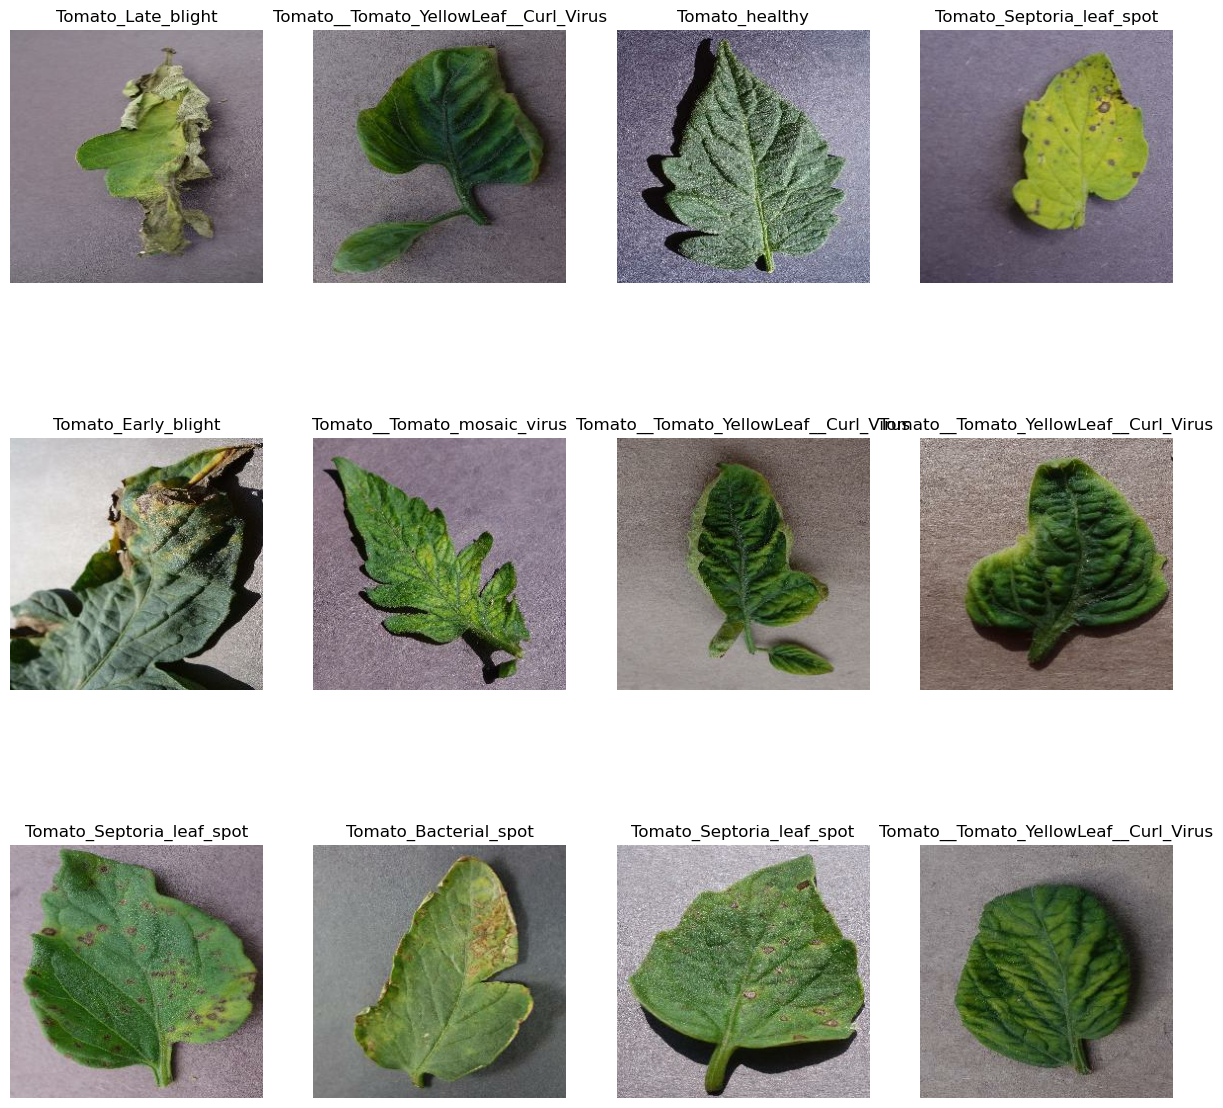

In [9]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

###### 80%==>training 
20%==> 10% validation, 10% test

In [10]:
train_size=0.8
len(dataset)*train_size

400.8

In [11]:
train_ds=dataset.take(400)
len(train_ds)

400

In [12]:
test_ds=dataset.skip(400)
len(test_ds)

101

In [13]:
val_size=0.1
len(dataset)*val_size


50.1

In [14]:
val_ds=test_ds.skip(50)
len(val_ds)

51

In [15]:
test_ds= test_ds.skip(51)
len(test_ds)

50

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds= get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

400

In [19]:
len(val_ds)

50

In [20]:
len(test_ds)

51

In [23]:
#cache read images from disk and in the next iteration, it will read them from memory
#prefecth load the next set of bacth from tyhe disk(by cpu), to save time durng training
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.experimental.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.experimental.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.experimental.AUTOTUNE)

In [24]:
#Images are rgb 256 , we need to resize( this is for input for prediction)  and rescale them
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [32]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

###### Apply CNN

In [36]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [37]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [39]:
model.compile(
    optimizer= 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [42]:
xccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccv

Epoch 1/10
400/400 [==============================] - 1535s 4s/step - loss: 1.4294 - accuracy: 0.4941 - val_loss: 0.9359 - val_accuracy: 0.6719
Epoch 2/10
400/400 [==============================] - 1163s 3s/step - loss: 0.7745 - accuracy: 0.7298 - val_loss: 0.5883 - val_accuracy: 0.7950
Epoch 3/10
400/400 [==============================] - 1278s 3s/step - loss: 0.5309 - accuracy: 0.8145 - val_loss: 0.5328 - val_accuracy: 0.8306
Epoch 4/10
400/400 [==============================] - 1203s 3s/step - loss: 0.4125 - accuracy: 0.8555 - val_loss: 0.4303 - val_accuracy: 0.8519
Epoch 5/10
400/400 [==============================] - 1542s 4s/step - loss: 0.3158 - accuracy: 0.8910 - val_loss: 0.2450 - val_accuracy: 0.9194
Epoch 6/10
400/400 [==============================] - 1852s 5s/step - loss: 0.2533 - accuracy: 0.9134 - val_loss: 0.2061 - val_accuracy: 0.9256
Epoch 7/10
400/400 [==============================] - 1803s 5s/step - loss: 0.2335 - accuracy: 0.9182 - val_loss: 0.2434 - val_accuracy:

In [45]:
score=model.evaluate(test_ds)
score

51/51 [==============================] - 45s 879ms/step - loss: 0.1397 - accuracy: 0.9504


[0.13970154523849487, 0.9503676295280457]

In [46]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 400}

In [48]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [49]:
history.history['accuracy']

[0.49406251311302185,
 0.7298437356948853,
 0.8145312666893005,
 0.85546875,
 0.8910156488418579,
 0.9134374856948853,
 0.9182031154632568,
 0.9310937523841858,
 0.9362499713897705,
 0.9437500238418579]

Text(0.5, 1.0, 'Training and Validation Accuracy')

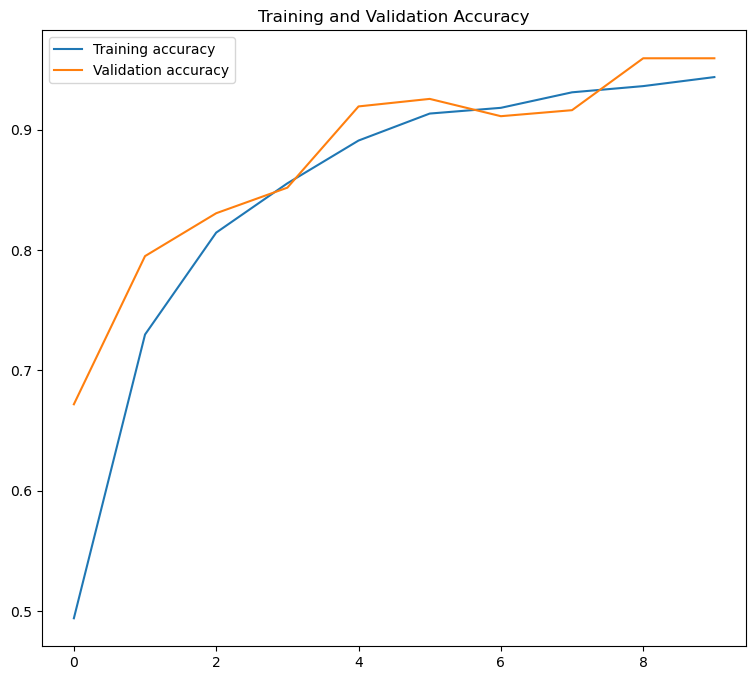

In [58]:
plt.figure(figsize=(20,8))

plt.subplot(1, 2 ,1)
plt.plot(range(EPOCHS), history.history['accuracy'], label='Training accuracy')
plt.plot(range(EPOCHS), history.history['val_accuracy'], label='Validation accuracy')

plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation loss')

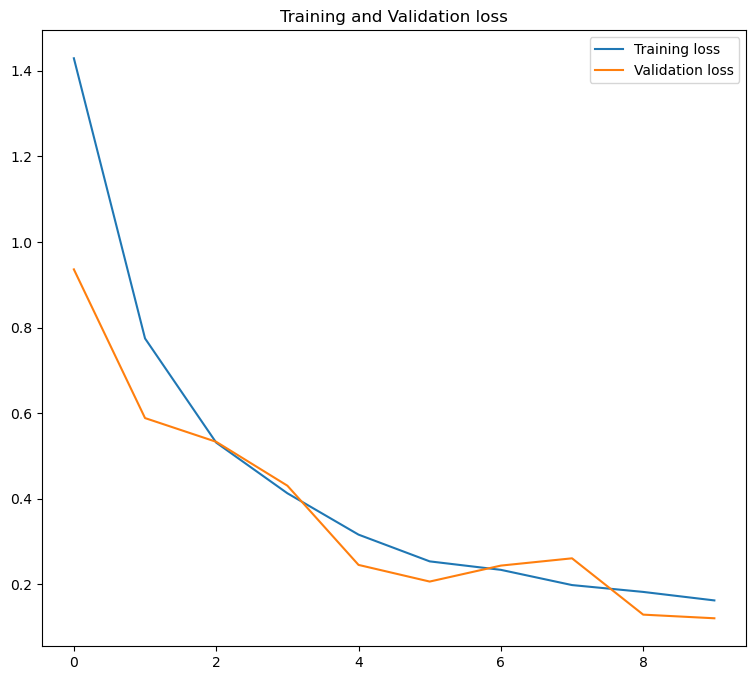

In [59]:
plt.figure(figsize=(20,8))

plt.subplot(1, 2 ,1)
plt.plot(range(EPOCHS), history.history['loss'], label='Training loss')
plt.plot(range(EPOCHS), history.history['val_loss'], label='Validation loss')

plt.legend()
plt.title("Training and Validation loss")

first image to predict
actual Label : Tomato__Target_Spot
1/1 [==============================] - 1s 994ms/step
Predicted label :  Tomato__Target_Spot


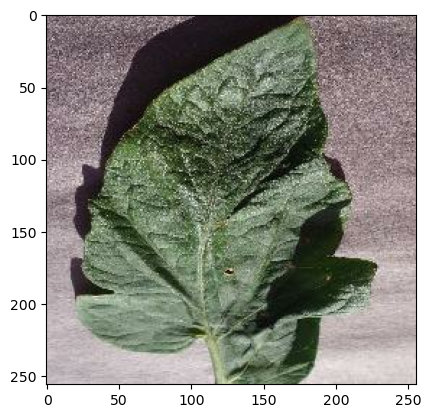

In [70]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
        first_img=images_batch[0].numpy().astype('uint8')
        first_label=labels_batch[0].numpy()
        
        print("first image to predict")
        plt.imshow(first_img)
        print("actual Label :", class_names[first_label])
        
        batch_prediction= model.predict(images_batch)
        print("Predicted label : ",class_names[np.argmax(batch_prediction[0])] )

#### function for inference

In [71]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 43ms/step


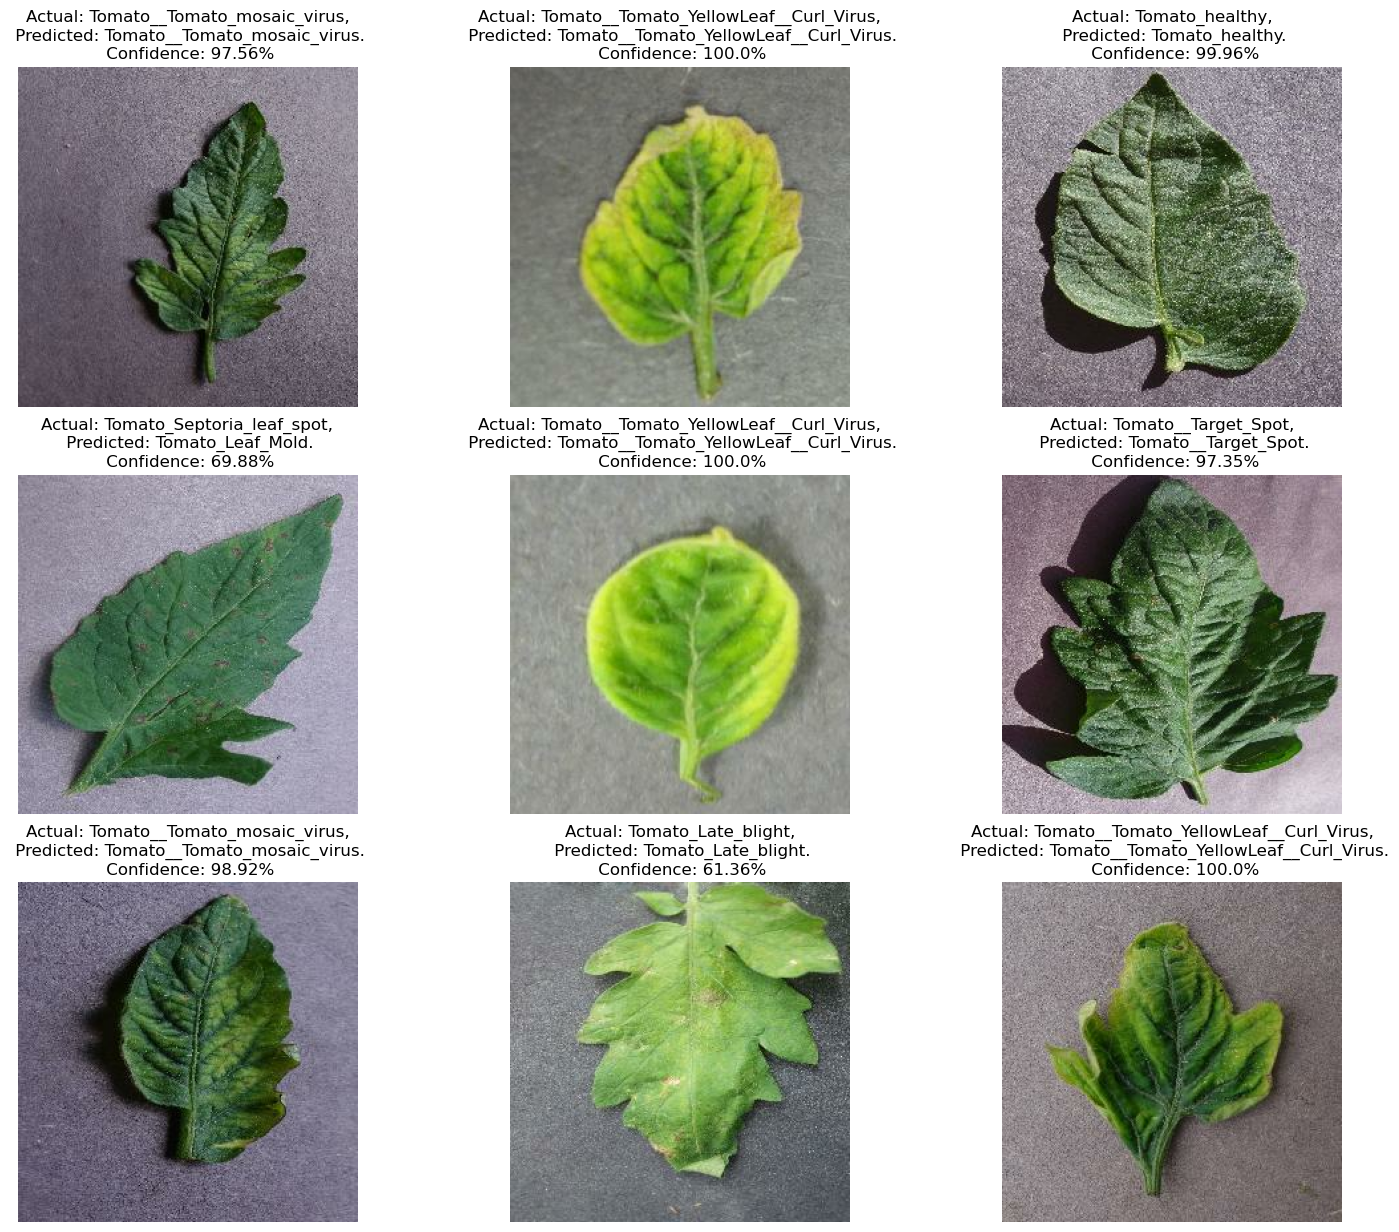

In [73]:
plt.figure(figsize=(18, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [76]:
import os
model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets


In [77]:
model.save("./tomatoes.h5")